In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install livelossplot
import pandas as pd
import numpy as np
import cv2
import glob
import warnings
from keras.layers import Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
img_size = 48
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
batch_size = 64
from sklearn.model_selection import train_test_split
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.metrics import classification_report

In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/PI/fer2013.csv')

In [ ]:
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

In [ ]:
df['pixels']=df['pixels'].astype("string")
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(df['emotion']).to_numpy()


In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [ ]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

In [ ]:
def CNN():
    model = Sequential(name='CNN')
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    return model

In [ ]:
CNN=CNN()


In [ ]:
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512     

In [ ]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'CNN'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [ ]:
CNN_history =CNN.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/50
392/392 [==============================] - 44s 32ms/step - loss: 1.9435 - accuracy: 0.2442 - val_loss: 1.8852 - val_accuracy: 0.1900

Epoch 00001: val_loss improved from inf to 1.88519, saving model to models/CNN.01-0.19.hdf5
Epoch 2/50
392/392 [==============================] - 12s 32ms/step - loss: 1.6361 - accuracy: 0.3651 - val_loss: 1.7124 - val_accuracy: 0.3838

Epoch 00002: val_loss improved from 1.88519 to 1.71242, saving model to models/CNN.02-0.38.hdf5
Epoch 3/50
392/392 [==============================] - 12s 32ms/step - loss: 1.4801 - accuracy: 0.4265 - val_loss: 1.3479 - val_accuracy: 0.4924

Epoch 00003: val_loss improved from 1.71242 to 1.34789, saving model to models/CNN.03-0.49.hdf5
Epoch 4/50
392/392 [==============================] - 12s 31ms/step - loss: 1.3698 - accuracy: 0.4752 - val_loss: 1.2263 - val_accuracy: 0.5307

Epoch 00004: val_loss improved from 1.34789 to 1.22625, saving model to models/CNN.04-0.53.hdf5
Epoch 5/50
392/392 [====================

In [ ]:

modelCNN_json = CNN.to_json()

with open("modelCNN_json.json", "w") as json_file1:
    json_file1.write(modelCNN_json)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Text(0.5, 1.0, 'Accuracy Curves CNN')

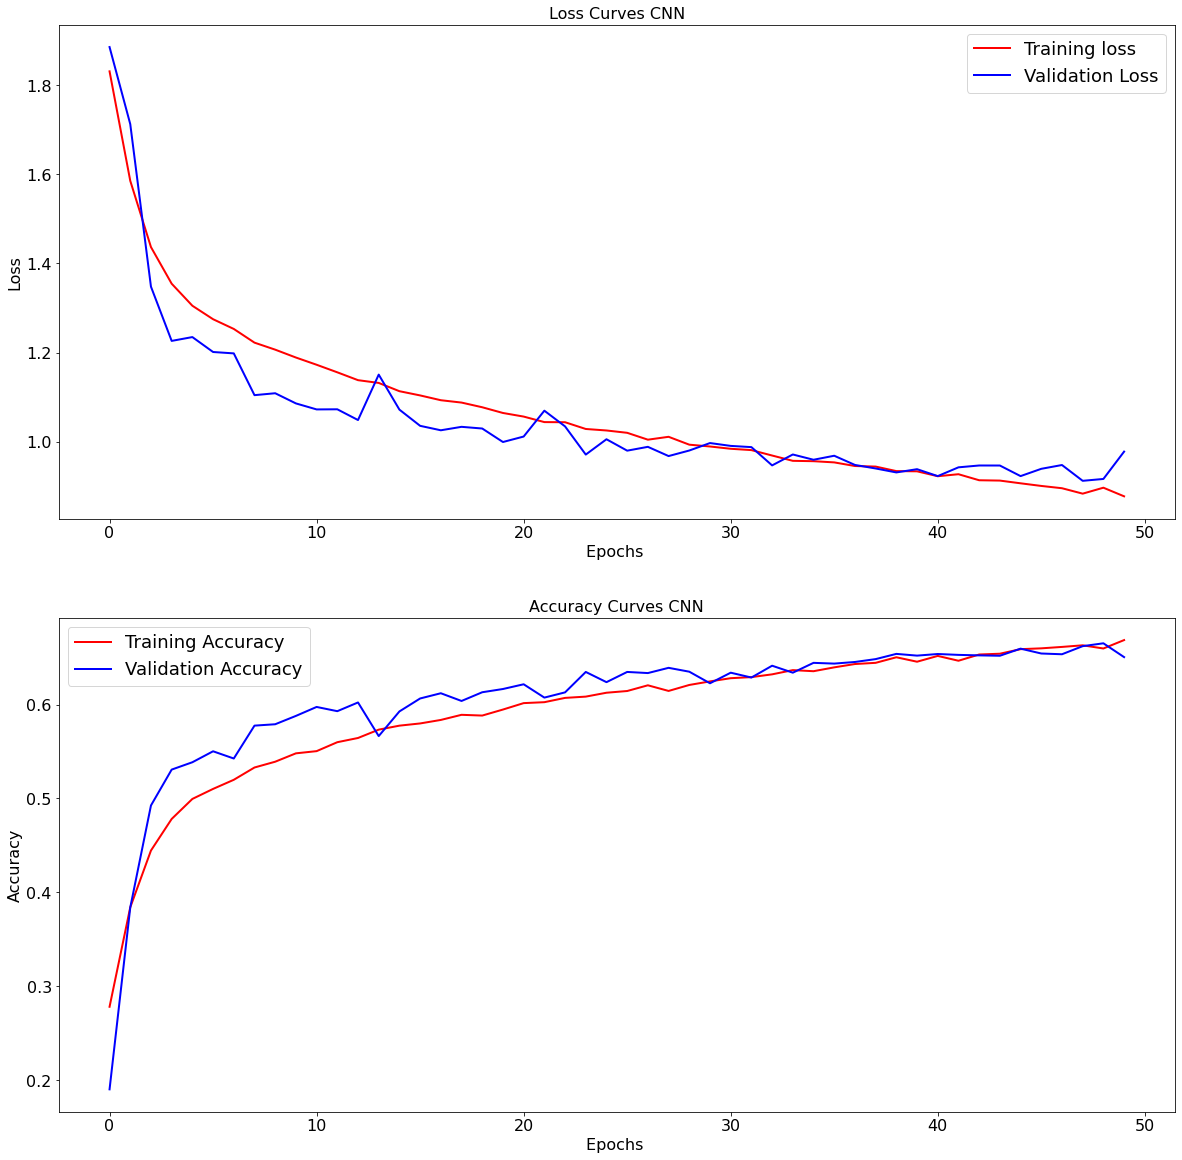

In [ ]:
fig,axes=plt.subplots(2,figsize=(20, 20))
history=CNN_history
# Loss Curves   
axes[0].plot(history.history['loss'],'r',linewidth=2.0)
axes[0].plot(history.history['val_loss'],'b',linewidth=2.0)
axes[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
axes[0].set_xlabel('Epochs ',fontsize=16)
axes[0].set_ylabel('Loss',fontsize=16)
axes[0].set_title('Loss Curves '+m,fontsize=16)

# Accuracy Curves
axes[1].plot(history.history['accuracy'],'r',linewidth=2.0)
axes[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
axes[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
axes[1].set_xlabel('Epochs ',fontsize=16)
axes[1].set_ylabel('Accuracy',fontsize=16)
axes[1].set_title('Accuracy Curves '+m,fontsize=16)

In [ ]:
# Accuracy Curves
ax[2].plot(history.history['accuracy'],'r',linewidth=2.0)
ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
ax[1].set_xlabel('Epochs ',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [ ]:
ypred=CNN.predict(xtest)
ypred_=np.argmax(ypred, axis=1)
ytest_=np.argmax(ytest, axis=1)
print(classification_report(ytest_, ypred_,digits=3))
CNN.score()

NameError: ignored

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
cm = confusion_matrix(ytest_, ypred_)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'
print(cm)

[[248   1  24  42  35  12  72]
 [ 16  26   3   6   1   2   5]
 [ 42   1 166  35  66  65  71]
 [  8   0   6 751   6  12  30]
 [ 38   0  40  52 239   7 154]
 [ 12   0  16  33   0 290  11]
 [ 15   0  10  64  32   9 457]]


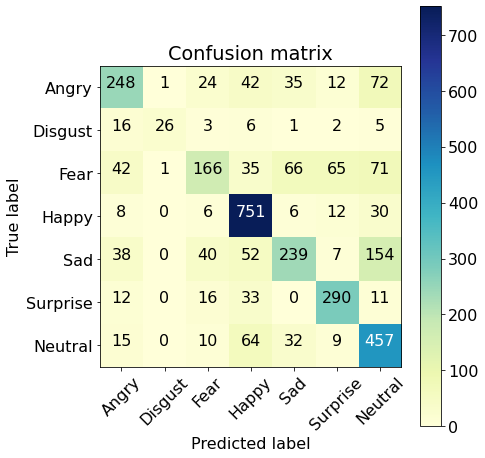

In [ ]:
fig = figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlGnBu)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
